In [71]:
import numpy as np
from acv_explainers import ACXplainer
from acv_explainers.utils import *
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from utils import MyTabNetClassifier
from utils import DatasetHelper, DATASETS_NAME
from sklearn.metrics import roc_auc_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')

GAMMA = 1.0
dataset = 't'
dataset_name = DATASETS_NAME[dataset]
model= 'X'

np.random.seed(0)
LAMBDA = 0.01
GAMMA = 1.0

D = DatasetHelper(dataset=dataset, feature_prefix_index=False)

for i in range(len(D.feature_names)):
    D.feature_names[i] = D.feature_names[i].replace(" ", "")
    
    
print('# Demonstration:', D.dataset_fullname)
print(D.to_markdown())

# Demonstration: EmployeeAttrition
| | Feature | Type | Value | Mutable |
| --- | --- | --- | :---: | :---: |
| 1 | Age | Integer | [18, 60] | False |
| 2 | BusinessTravel | Integer | [0, 2] | True |
| 3 | Education | Integer | [1, 5] | False |
| 4 | JobLevel | Integer | [1, 5] | False |
| 5 | MonthlyIncome | Integer | [1009, 19999] | True |
| 6 | OverTime | Bool | {False: 0, True: 1} | True |
| 7 | PercentSalaryHike | Integer | [11, 25] | True |
| 8 | OutstandingPerformanceRating | Bool | {False: 0, True: 1} | False |
| 9 | TotalWorkingYears | Integer | [0, 40] | False |
| 10 | TrainingTimesLastYear | Integer | [0, 6] | False |
| 11 | WorkLifeBalance | Integer | [1, 4] | True |
| 12 | YearsAtCompany | Integer | [0, 40] | False |
| 13 | YearsInCurrentRole | Integer | [0, 18] | False |
| 14 | YearsSinceLastPromotion | Integer | [0, 15] | False |
| 15 | YearsWithCurrManager | Integer | [0, 17] | False |
| 16 | Department | Category | HumanResources <br> ResearchAndDevelopment <br> Sales 

In [ ]:
## run the following line to run experiment and get results

# X_tr, X_ts, y_tr, y_ts = D.train_test_split()

# if(model=='L'):
#     print('* Classifier: LogisticRegression')
#     mdl = LogisticRegression(penalty='l2', C=1.0, solver='liblinear')
#     print('\t* C: {}'.format(mdl.C)); print('\t* penalty: {}'.format(mdl.penalty));
# elif(model=='X'):
#     print('* Classifier: LightGBM')
#     mdl = LGBMClassifier(n_estimators=50, num_leaves=8)
#     print('\t* n_estimators: {}'.format(mdl.n_estimators)); print('\t* num_leaves: {}'.format(mdl.num_leaves));
# elif(model=='T'):
#     print('* Classifier: TabNet')
#     mdl = MyTabNetClassifier(D.feature_types, verbose=0)
    
# mdl = mdl.fit(X_tr, y_tr, X_vl=X_ts, y_vl=y_ts) if model=='T' else mdl.fit(X_tr, y_tr)
# X = X_tr[mdl.predict(X_tr)==1]; X_vl = X_ts[mdl.predict(X_ts)==1];
# print('\t* train score: ', mdl.score(X_tr, y_tr)); print('\t* train denied: ', X.shape[0]);
# print('\t* test score: ', mdl.score(X_ts, y_ts)); print('\t* test denied: ', X_vl.shape[0]); print();

# x_train = X_tr.copy()
# x_test = X_ts.copy()
# y_train = mdl.predict(X_tr)
# y_test = mdl.predict(X_ts)

# ### Train Explainer (ACXplainer)
# ac_explainer = ACXplainer(classifier=True, n_estimators=20, max_depth=12)
# ac_explainer.fit(x_train, y_train)

# print('# Trained ACXplainer -- score = {}'.format(accuracy_score(y_test, ac_explainer.predict(x_test))))

# x, y = x_test[:500], y_test[:500]
# x_rules, y_rules = x_train[:1000], y_train[:1000]

# columns_name = D.feature_names

# results = RunExperiments(ac_explainer, x_train, x_test, y_train, y_test, columns_name, model=mdl)

# results.run_sufficient_rules(x_rules, y_rules, pi_level=0.9)

In [72]:
results = load_model('EmployeeAttritionCR_results'.format(dataset_name))

In [4]:
def get_sr_results(x_test, rules, x_rules, y_rules, s_star, predict):
    N = rules.shape[0]
    d = rules.shape[1]
    
    coverages = []
    accuracies = []
    supports = []
    for idx in tqdm(range(N)):
        x_in = np.prod([(x_test[:, s] <= rules[idx, s, 1]) * (x_test[:, s] > rules[idx, s, 0])
                        for s in range(d)], axis=0).astype(bool)
        
        if  np.sum(x_in) == 0:
            continue
            
        coverage = np.mean(x_in)
        accuracy = np.mean(predict(x_test[x_in]) == y_rules[idx].reshape(1, -1))
        
        coverages.append(coverage)
        accuracies.append(accuracy)
        supports.append(len(s_star[idx]))
        
    return coverages, accuracies, supports, rules

In [4]:
coverages_sr, accuracies_sr, supports_sr, rules_sr = get_sr_results(results.x_test, results.rules, results.x_rules, results.y_rules,
                                                                        results.S_star_se, results.acv_explainer.predict)

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 664.66it/s]


In [5]:
# N = x_test.shape[0]
N = results.rules.shape[0]
print('SR: Coverage = {} - Accuracy = {} - Support = {}'.format(np.sum(coverages_sr)/N, np.sum(accuracies_sr)/N, 
                                                            np.sum(supports_sr)/N))


SR: Coverage = 0.5728423913043478 - Accuracy = 0.9348926956869634 - Support = 0.984


In [6]:
# N = x_test.shape[0]
# N = results.rules.shape[0]
print('SR STD: Coverage = {} - Accuracy = {} - Support = {}'.format(np.var(coverages_sr), np.var(accuracies_sr), 
                                                            np.var(supports_sr)))


SR STD: Coverage = 0.015858878706276634 - Accuracy = 0.002284977771868051 - Support = 0.17555213043581816


In [5]:
from anchor import utils
from anchor import anchor_tabular

In [7]:
columns_names = ['F{}'.format(i) for i in range(results.x_train.shape[1])]
columns_id = {}
for i, col in enumerate(columns_names):
    columns_id[col] = i

{'F0': 0,
 'F1': 1,
 'F2': 2,
 'F3': 3,
 'F4': 4,
 'F5': 5,
 'F6': 6,
 'F7': 7,
 'F8': 8,
 'F9': 9,
 'F10': 10,
 'F11': 11,
 'F12': 12,
 'F13': 13,
 'F14': 14,
 'F15': 15,
 'F16': 16,
 'F17': 17,
 'F18': 18,
 'F19': 19,
 'F20': 20,
 'F21': 21,
 'F22': 22,
 'F23': 23,
 'F24': 24,
 'F25': 25,
 'F26': 26}

In [8]:
explainer = anchor_tabular.AnchorTabularExplainer(
    D.target_labels,
    columns_names,
    results.x_train)

In [9]:
def get_anchor_results(explainer, x_test, x_train, predict, pi, columns_id):
    N = x_train.shape[0]
    d = x_train.shape[1]
    rules = np.ones(shape=(N, d, 2))
    rules[:, :, 0] = -1e+10
    rules[:, :, 1] = 1e+10
    
    coverages = []
    accuracies = []
    supports = []
    for idx in tqdm(range(N)):
        exp = explainer.explain_instance(x_train[idx], predict, threshold=pi)
        for r in exp.names():
            r_split = r.split()
            
            if len(r_split) == 3:
                col_id = columns_id[r_split[0]]
                if r_split[1] == '<' or r_split[1] == '<=':
                    rules[idx, col_id, 1] = r_split[2]
                elif r_split[1] == '>' or r_split[1] == '>=':
                    rules[idx, col_id, 0] = r_split[2]
                else:
                    raise ValueError
            elif len(r_split) == 5:
                col_id = columns_id[r_split[2]]
                rules[idx, col_id, 0] = r_split[0]
                rules[idx, col_id, 0] = r_split[-1]
            else:
                raise ValueError

        x_train_in = np.prod([(x_train[:, s] <= rules[idx, s, 1]) * (x_train[:, s] > rules[idx, s, 0])
                        for s in range(d)], axis=0).astype(bool)
        x_in = np.prod([(x_test[:, s] <= rules[idx, s, 1]) * (x_test[:, s] > rules[idx, s, 0])
                        for s in range(d)], axis=0).astype(bool)
        
        if np.sum(x_train_in) * np.sum(x_in) == 0:
            continue
            
#         if np.abs(np.mean(x_train_in)-exp.coverage())>0.01:
#             print(r)
#             print(np.mean(x_train_in), exp.coverage())
#             raise Warning('Inconsistency of the rules for this obs')
            
        
        coverage = np.mean(x_in)
        accuracy = np.mean(predict(x_test[x_in]) == predict(x_train[idx].reshape(1, -1)))
        
        coverages.append(coverage)
        accuracies.append(accuracy)
        supports.append(len(exp.names()))
        
    return coverages, accuracies, supports, rules

        

In [48]:
def get_anchor_stab(explainer, x_test, predict, pi, columns_id):
    N = x_test.shape[0]
    d = x_test.shape[1]
    
#     coverages = []
#     accuracies = []
    supports = []
    
    for idx in tqdm(range(N)):
        exp = explainer.explain_instance(x_train[idx], predict, threshold=pi)
        supports.append(exp.names())
        
    return supports

        

In [ ]:
get_anchor_stab(explainer, results)

In [13]:
coverages, accuracies, supports, rules = get_anchor_results(explainer, results.x_test, results.x_rules, 
                                                            results.acv_explainer.predict, pi=0.9, columns_id=columns_id)

100%|███████████████████████████████████████| 1000/1000 [07:43<00:00,  2.16it/s]


In [14]:
# N = x_test.shape[0]
# N = 500
print('ANCHORS: Coverage = {} - Accuracy = {} - Support = {}'.format(np.sum(coverages)/N, np.sum(accuracies)/N, 
                                                            np.sum(supports)/N))


ANCHORS: Coverage = 0.6989157608695652 - Accuracy = 0.938789859789333 - Support = 0.83


In [15]:
# N = x_test.shape[0]
# N = 500
print('ANCHORS STD: Coverage = {} - Accuracy = {} - Support = {}'.format(np.var(coverages), np.var(accuracies), 
                                                            np.var(supports)))


ANCHORS STD: Coverage = 0.06127852893031416 - Accuracy = 0.0038236599380743032 - Support = 3.374632258401943


<AxesSubplot:ylabel='count'>

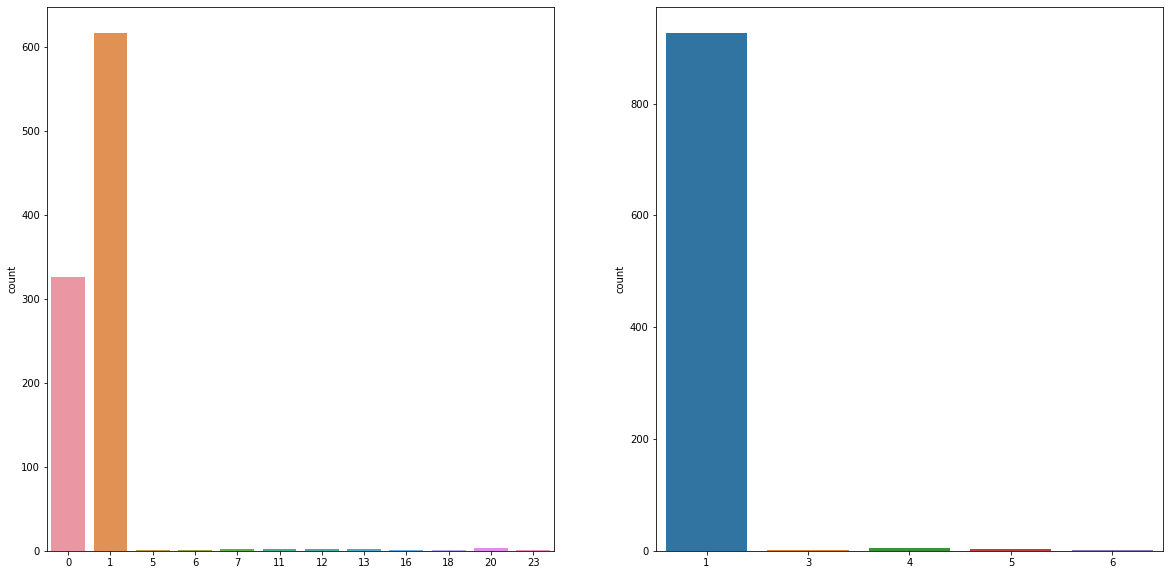

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.countplot(ax = ax[0], x=supports)
sns.countplot(ax = ax[1], x=supports_sr)

In [22]:
unique, count = np.unique(supports, return_counts=True)
unique_sr, count_sr = np.unique(supports_sr, return_counts=True)

In [23]:
count_support = dict(zip(unique, count))
count_support_sr = dict(zip(unique_sr, count_sr))

In [24]:
count_support

{0: 326,
 1: 616,
 5: 1,
 6: 1,
 7: 2,
 11: 2,
 12: 2,
 13: 2,
 16: 1,
 18: 1,
 20: 3,
 23: 1}

In [25]:
count_support_sr

{1: 926, 3: 2, 4: 5, 5: 4, 6: 2}

# Stability

In [77]:
def get_anchor_stab(explainer, x_test, predict, pi):
    N = x_test.shape[0]
    d = x_test.shape[1]
    
#     coverages = []
#     accuracies = []
    supports = []
    
    for idx in tqdm(range(N)):
        exp = explainer.explain_instance(x_test[idx], predict, threshold=pi)
        supports.append(exp.names())
        
    return supports

def compute_stability(results, explainer, size, nb_perturb, eps):
    stabs = []
    stabs_sr = []
    for idx in range(size):
        x = results.x_test[idx]
        y = results.y_test[idx]

        d = results.x_test.shape[1]
        rdm = eps*np.random.randn(nb_perturb * d).reshape(nb_perturb, d) 
        x_rdm = rdm + x
        y_rdm = np.array(nb_perturb*[y])

#         coverages, accuracies, supports, rules = get_anchor_results(explainer, results.x_test[:1], x_rdm, 
#                                                                     results.acv_explainer.predict, pi=0.9, 
#                                                                     columns_id=columns_id)
#         stab = np.unique(rules, axis=0).shape[0]
       
        rules = get_anchor_stab(explainer, x_rdm, results.acv_explainer.predict, pi=0.9)
        stab = np.unique(rules).shape[0]
       
        pi_level = 0.9

        sdp_importance_se, sdp_index_se, size_se, sdp_se = \
                    results.acv_explainer.importance_sdp_rf(x_rdm, y_rdm,
                                                         results.x_train, results.y_train,
                                                         stop=False,
                                                         pi_level=pi_level)

        sdp_se

        S_star_se, N_star_se = get_active_null_coalition_list(sdp_index_se, size_se)

        # sdp_rules, rules_sr, sdp_all, rules_data, w_rules = results.acv_explainer.compute_sdp_maxrules(
        #     x_rdm, y_rdm, results.x_train, results.y_train, S_star_se, verbose=True)

        sdp_rules, rules_sr = results.acv_explainer.compute_sdp_rule(
            x_rdm, y_rdm, results.x_train, results.y_train, S_star_se)

        stab_sr = np.unique(rules_sr, axis=0).shape[0]
        
        stabs.append(stab)
        stabs_sr.append(stab_sr)
        print(np.mean(stabs_sr), np.mean(stabs))
        print(np.var(stabs_sr), np.var(stabs))
    return stabs, stabs_sr

In [78]:
stabs_01, stabs_sr_01 = compute_stability(results, explainer, size=100, nb_perturb=50, eps=0.1)

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 20.00it/s]


1.0 10.0
0.0 0.0


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 19.46it/s]


1.0 11.5
0.0 2.25


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 20.58it/s]


1.3333333333333333 11.333333333333334
0.2222222222222222 1.5555555555555556


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 15.97it/s]


1.25 11.0
0.1875 1.5


100%|███████████████████████████████████████████| 10/10 [00:37<00:00,  3.79s/it]


1.2 18.8
0.16 244.56


100%|███████████████████████████████████████████| 10/10 [00:41<00:00,  4.17s/it]


1.1666666666666667 18.0
0.13888888888888887 207.0


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 19.10it/s]


1.1428571428571428 17.428571428571427
0.12244897959183676 179.38775510204079


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 18.52it/s]


1.125 16.75
0.109375 160.1875


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 19.44it/s]


1.1111111111111112 16.77777777777778
0.09876543209876544 142.39506172839506


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 19.79it/s]


1.1 16.5
0.09 128.85


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 19.84it/s]


1.0909090909090908 16.272727272727273
0.08264462809917354 117.65289256198348


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 18.22it/s]


1.0833333333333333 16.0
0.07638888888888888 108.66666666666667


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 19.95it/s]


1.0769230769230769 15.538461538461538
0.07100591715976333 102.8639053254438


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 22.02it/s]


1.0714285714285714 15.5
0.06632653061224487 95.53571428571429


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 19.22it/s]


1.0666666666666667 15.4
0.06222222222222224 89.30666666666669


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 18.72it/s]


1.0625 15.1875
0.05859375 84.40234375


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 20.43it/s]


1.0588235294117647 14.941176470588236
0.05536332179930797 80.40830449826991


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 20.44it/s]


1.0555555555555556 14.777777777777779
0.05246913580246914 76.39506172839508


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 19.00it/s]


1.0526315789473684 14.68421052631579
0.049861495844875335 72.53185595567868


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 17.78it/s]


1.05 14.6
0.047500000000000014 69.03999999999999


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 23.91it/s]


1.0476190476190477 14.523809523809524
0.04535147392290251 65.86848072562356


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 19.95it/s]


1.0454545454545454 14.590909090909092
0.04338842975206613 62.96900826446281


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 20.14it/s]


1.0434782608695652 14.478260869565217
0.04158790170132326 60.510396975425316


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.68it/s]


1.0416666666666667 14.333333333333334
0.03993055555555556 58.47222222222222


100%|███████████████████████████████████████████| 10/10 [00:48<00:00,  4.89s/it]


1.04 14.12
0.03840000000000001 57.225600000000014


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 18.71it/s]


1.0384615384615385 14.115384615384615
0.03698224852071005 55.025147928994095


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 19.94it/s]


1.037037037037037 14.148148148148149
0.035665294924554176 53.0150891632373


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 18.92it/s]


1.0357142857142858 14.107142857142858
0.03443877551020409 51.16709183673468


100%|███████████████████████████████████████████| 10/10 [00:41<00:00,  4.18s/it]


1.0344827586206897 15.344827586206897
0.033293697978596916 92.294887039239


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 20.42it/s]


1.0333333333333334 15.233333333333333
0.0322222222222222 89.5788888888889


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 19.92it/s]


1.032258064516129 15.161290322580646
0.031217481789802305 86.84495317377731


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 20.54it/s]


1.0625 15.15625
0.05859375 84.1318359375


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 21.97it/s]


1.0606060606060606 15.121212121212121
0.05693296602387511 81.6216712580349


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.74it/s]


1.0588235294117647 15.176470588235293
0.055363321799307974 79.32179930795849


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 16.77it/s]


1.0571428571428572 15.057142857142857
0.05387755102040818 77.53959183673467


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 19.62it/s]


1.0555555555555556 15.0
0.05246913580246914 75.5


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 20.25it/s]


1.054054054054054 15.0
0.05113221329437544 73.45945945945945


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 20.71it/s]


1.0526315789473684 14.894736842105264
0.049861495844875335 71.93628808864268


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 19.78it/s]


1.0512820512820513 14.897435897435898
0.048652202498356334 70.09204470742931


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 21.56it/s]


1.075 14.8
0.06937499999999999 68.71000000000001


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 17.97it/s]


1.0731707317073171 14.853658536585366
0.06781677572873292 67.14931588340274


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 16.27it/s]


1.0714285714285714 14.738095238095237
0.06632653061224489 66.09807256235824


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 20.72it/s]


1.069767441860465 14.744186046511627
0.06489994591671175 64.56246619794483


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 21.03it/s]


1.0681818181818181 14.840909090909092
0.06353305785123965 63.4974173553719


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 21.09it/s]


1.0666666666666667 14.844444444444445
0.0622222222222222 62.08691358024689


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 21.81it/s]


1.108695652173913 14.73913043478261
0.14035916824196598 61.23629489603024


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.97it/s]


1.1063829787234043 14.702127659574469
0.13761883205070166 59.996378451788125


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 22.58it/s]


1.1041666666666667 14.645833333333334
0.1349826388888889 58.89539930555554


100%|███████████████████████████████████████████| 10/10 [00:37<00:00,  3.70s/it]


1.1020408163265305 15.36734693877551
0.1324448146605581 82.68138275718452


100%|███████████████████████████████████████████| 10/10 [00:44<00:00,  4.48s/it]


1.1 16.06
0.12999999999999998 104.53639999999997


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 21.71it/s]


1.0980392156862746 15.941176470588236
0.1276432141484045 103.19261822376014


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 21.45it/s]


1.0961538461538463 15.826923076923077
0.12536982248520714 101.87389053254432


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 19.89it/s]


1.0943396226415094 15.79245283018868
0.1231755072979708 100.01352794588821


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 20.12it/s]


1.0925925925925926 15.703703703703704
0.12105624142661175 98.57887517146776


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 21.61it/s]


1.0909090909090908 15.581818181818182
0.11900826446280988 97.58876033057852


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 20.93it/s]


1.0892857142857142 15.535714285714286
0.11702806122448979 95.96301020408166


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 21.08it/s]


1.105263157894737 15.456140350877194
0.12927054478301014 94.63404124345954


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 21.20it/s]


1.103448275862069 15.448275862068966
0.1272294887039239 93.00594530321047


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 20.40it/s]


1.1016949152542372 15.35593220338983
0.12525136455041655 91.92415972421719


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 22.24it/s]


1.1 15.283333333333333
0.12333333333333332 90.7030555555556


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 20.10it/s]


1.098360655737705 15.295081967213115
0.12147272238645526 89.22440204246169


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 21.28it/s]


1.096774193548387 15.17741935483871
0.11966701352757546 88.62981269510925


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 20.59it/s]


1.0952380952380953 15.19047619047619
0.11791383219954646 87.23356009070294


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 22.73it/s]


1.09375 15.125
0.1162109375 86.140625


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 22.61it/s]


1.0923076923076922 15.046153846153846
0.11455621301775148 85.21325443786982


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 20.49it/s]


1.0909090909090908 14.954545454545455
0.11294765840220386 84.46763085399449


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 22.30it/s]


1.0895522388059702 14.91044776119403
0.11138338159946536 83.33526397861439


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 21.15it/s]


1.088235294117647 14.882352941176471
0.10986159169550175 82.16262975778545


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.43it/s]


1.0869565217391304 14.840579710144928
0.1083805923125394 81.09052720016801


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 22.07it/s]


1.0857142857142856 14.8
0.10693877551020406 80.04571428571431


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 21.82it/s]


1.0845070422535212 14.774647887323944
0.10553461614758979 78.9633009323547


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 22.47it/s]


1.0972222222222223 14.76388888888889
0.11554783950617284 77.87480709876546


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 21.10it/s]


1.095890410958904 14.712328767123287
0.11409270031900919 76.9994370425971


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 19.49it/s]


1.0945945945945945 14.64864864864865
0.11267348429510593 76.25493060628197


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 21.17it/s]


1.0933333333333333 14.64
0.11128888888888888 75.24373333333334


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 22.48it/s]


1.0921052631578947 14.578947368421053
0.1099376731301939 74.5332409972299


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 21.81it/s]


1.103896103896104 14.545454545454545
0.11907572946533992 73.65053128689492


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 21.64it/s]


1.1025641025641026 14.512820512820513
0.11768573307034849 72.78829717291258


100%|███████████████████████████████████████████| 10/10 [00:43<00:00,  4.39s/it]


1.1012658227848102 14.443037974683545
0.11632751161672804 72.24675532767185


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 20.15it/s]


1.1 14.4375
0.11500000000000002 71.34609375


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 20.14it/s]


1.0987654320987654 14.444444444444445
0.11370217954580095 70.46913580246915


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 20.05it/s]


1.0975609756097562 14.426829268292684
0.11243307555026769 69.63488994646042


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 21.60it/s]


1.0963855421686748 14.373493975903614
0.11119175497169398 69.02917694875887


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 21.35it/s]


1.0952380952380953 14.380952380952381
0.10997732426303854 68.21201814058956


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 21.93it/s]


1.0941176470588236 14.4
0.10878892733564013 67.44000000000001


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 20.61it/s]


1.0930232558139534 14.348837209302326
0.10762574364521366 66.87831260140615


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 22.49it/s]


1.0919540229885059 14.35632183908046
0.10648698639186162 66.11441405733913


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 22.72it/s]


1.0909090909090908 14.352272727272727
0.10537190082644629 65.3645402892562


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 20.36it/s]


1.101123595505618 14.337078651685394
0.11336952404999369 64.65042292639818


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 15.03it/s]


1.1 14.3
0.11222222222222224 64.05444444444446


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 25.91it/s]


1.098901098901099 14.285714285714286
0.11109769351527593 63.36891679748823


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 20.47it/s]


1.108695652173913 14.271739130434783
0.11862003780718336 62.69789697542533


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 20.69it/s]


1.118279569892473 14.258064516129032
0.1257948895826107 62.04092958723551


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 22.04it/s]


1.127659574468085 14.25531914893617
0.13263920325939343 61.38162064282481


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 21.30it/s]


1.1263157894736842 14.242105263157894
0.1314127423822715 60.75191135734073


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 21.05it/s]


1.125 14.177083333333334
0.13020833333333334 60.520724826388886


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 20.71it/s]


1.134020618556701 14.1340206185567
0.13667764905941118 60.07482197895631


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 21.89it/s]


1.1326530612244898 14.10204081632653
0.1354643898375677 59.561016243232004


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 23.13it/s]


1.1313131313131313 14.05050505050505
0.13427201305989186 59.21967146209571


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 21.27it/s]

1.13 14.03
0.1331 58.6691


In [79]:
np.mean(stabs_01)

14.03

In [80]:
np.var(stabs_01)

58.6691

In [81]:
np.mean(stabs_sr_01)

1.13

In [82]:
np.var(stabs_sr_01)

0.1331